In [1]:
import sys
sys.path.append("../")
from utils import *
sys.path.append("../Google_HDRplus/")
from merge_utils import *

In [2]:
bk_lvl = 50
print("black level of the sensor: ", bk_lvl)

black level of the sensor:  50


In [3]:
rIm=read_raw("../static_videos/lowlight3_frame16_bunny_3.raw", frame =16)
rIm = rIm[:, :2048, :3584]

## scene visualization: hand and bunny move against the background board

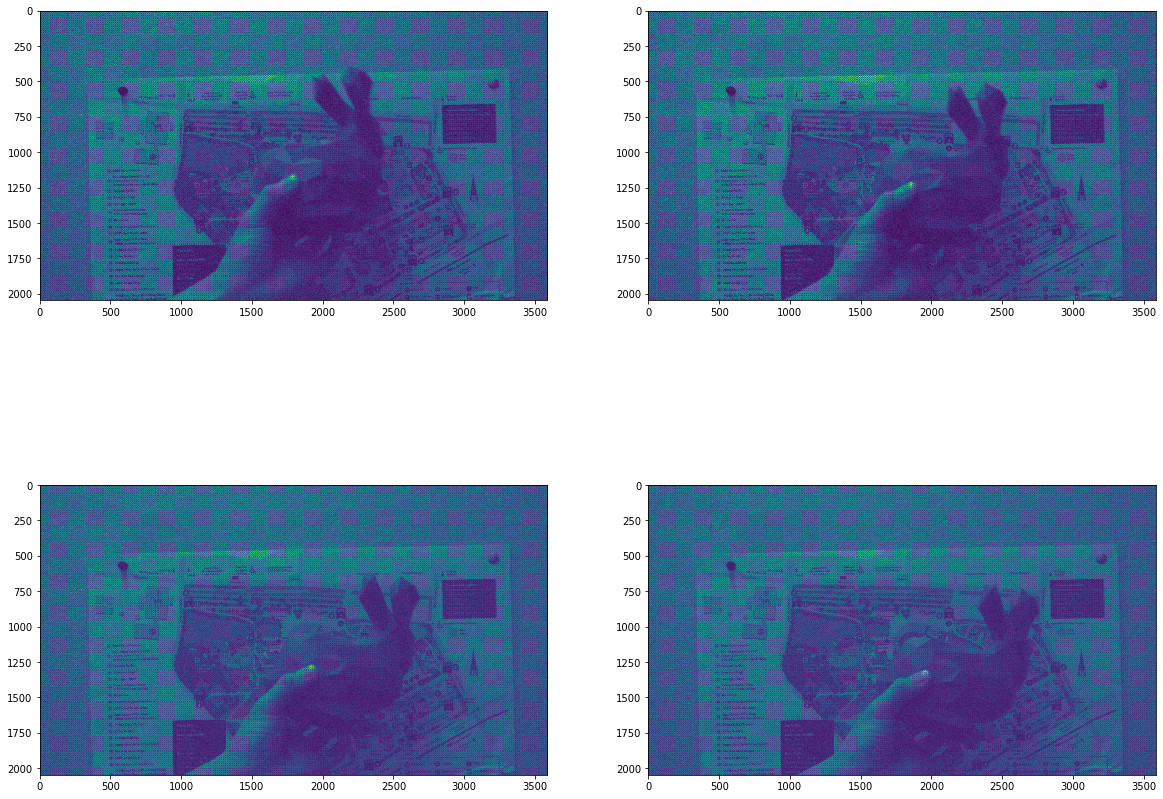

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(20, 16))
ax[0][0].imshow(rIm[0])
ax[0][1].imshow(rIm[5])
ax[1][0].imshow(rIm[10])
ax[1][1].imshow(rIm[15])
plt.show()

## single raw frame

In [4]:
ref_idx = 0
rIm_single = rIm[ref_idx] - bk_lvl
rIm_single = np.clip(rIm_single, 0, 1023)
print_stat("rIm_single",rIm_single)
bit_length = np.log2(rIm_single.max())
print("bit_length", bit_length)

rIm_single  shape:  (2048, 3584) dtype: int16
rIm_single stat: max: 27, min: 0, mean: 6.548732621329171, std: 3.5766085926180717
bit_length 4.7548876


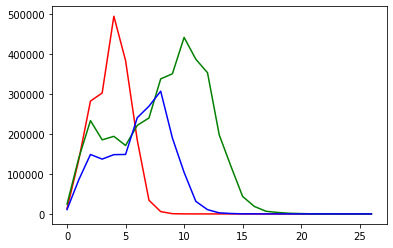

In [5]:
plot_histogram(rIm_single, bit_length)

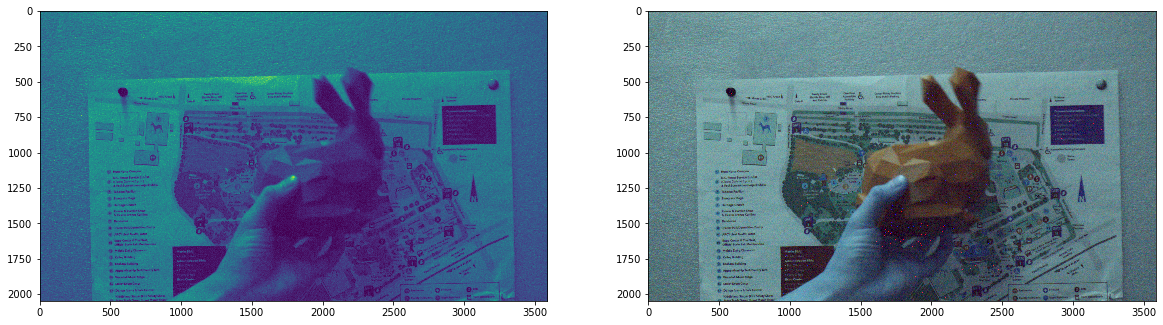

In [6]:
rgbIm_single = demosaic(rIm_single)
rgbIm_adj_single = adjustColor(rgbIm_single,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rIm_single)
ax[1].imshow(rgbIm_adj_single)
plt.show()

## simple summation all frames

In [7]:
rIm_sum = rIm.sum(axis = 0) - bk_lvl* rIm.shape[0]
print_stat("rIm_sum", rIm_sum)
bit_length = np.log2(rIm_sum.max())
print("bit_length", bit_length)

rIm_sum  shape:  (2048, 3584) dtype: int64
rIm_sum stat: max: 425, min: 2, mean: 105.40667057037354, std: 54.342939102707916
bit_length 8.731319031025064


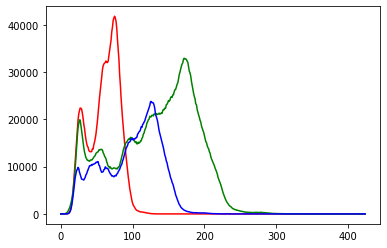

In [8]:
plot_histogram(rIm_sum, bit_length)

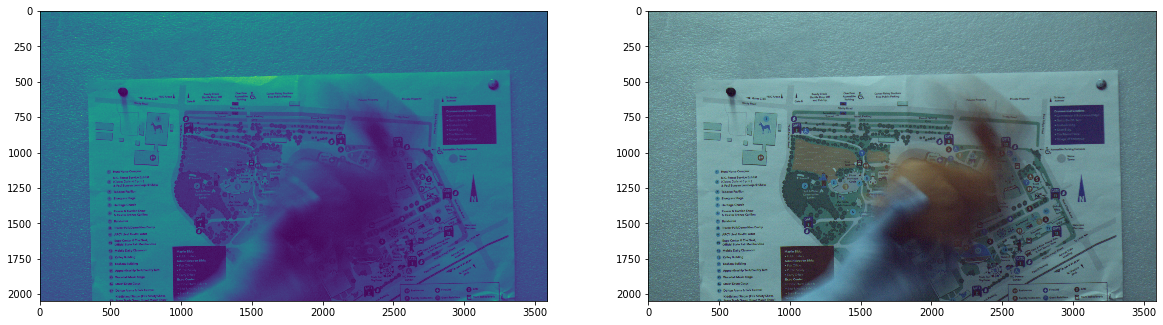

In [9]:
rIm_sum = np.clip(rIm_sum, 0, 1023)
rgbIm = demosaic(rIm_sum)
rgbIm_adj = adjustColor(rgbIm,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rIm_sum)
ax[1].imshow(rgbIm_adj)
plt.show()

## flow pre-warping and merge

In [10]:
# merge_util: dist set 1420.4
final = rIm[ref_idx].copy().astype(np.float64)
for idx in range(1, 16):
    print("merge {}th raw image...".format(idx))
    ref = rIm[ref_idx]
    alt = np.load("warped_{}.npy".format(idx))
    H, W = ref.shape
    bi_align_field = np.zeros((H//16-1, W//16-1, 2), dtype=ref.dtype)
    merged_frame = merge(ref, alt, bi_align_field)
    final += merged_frame

merge 1th raw image...
merge 2th raw image...
merge 3th raw image...
merge 4th raw image...
merge 5th raw image...
merge 6th raw image...
merge 7th raw image...
merge 8th raw image...
merge 9th raw image...
merge 10th raw image...
merge 11th raw image...
merge 12th raw image...
merge 13th raw image...
merge 14th raw image...
merge 15th raw image...


In [11]:
rIm_merge = final[32:-32, 32:-32] - bk_lvl* rIm.shape[0]
rIm_merge = rIm_merge.astype(np.int16)
rIm_merge = np.clip(rIm_merge, 0, 1023)
print_stat("rIm_merge", rIm_merge)
bit_length = np.log2(rIm_merge.max())
print("bit_length", bit_length)

rIm_merge  shape:  (1984, 3520) dtype: int16
rIm_merge stat: max: 410, min: 0, mean: 103.78774442700697, std: 56.046566325868056
bit_length 8.679481


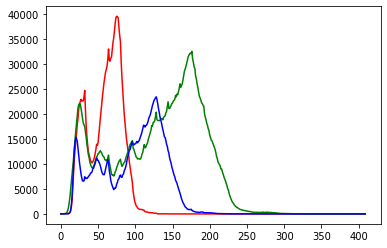

In [12]:
plot_histogram(rIm_merge, bit_length)

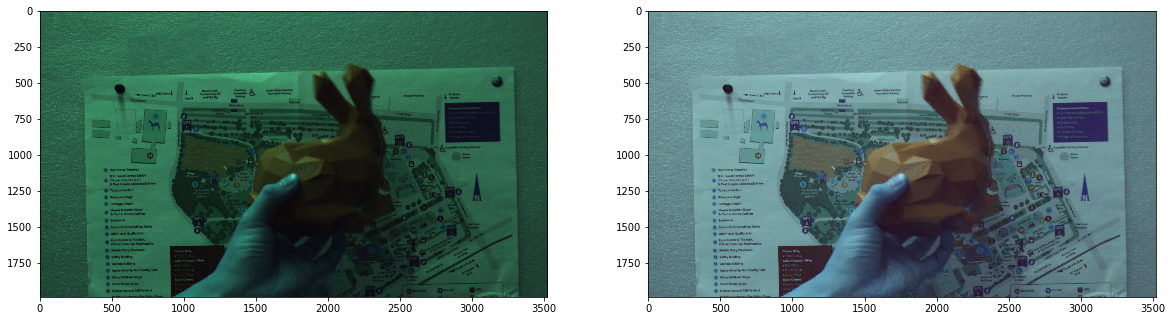

In [13]:
rgbIm_merge = demosaic(rIm_merge)
rgbIm_adj_merge = adjustColor(rgbIm_merge,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rgbIm_merge)
ax[1].imshow(rgbIm_adj_merge)
plt.show()

In [14]:
import cv2
cv2.imwrite("rgbIm_adj_merge_ref{}.png".format(ref_idx), rgbIm_adj_merge[..., ::-1])
cv2.imwrite("rgbIm_adj_ref{}.png".format(ref_idx), rgbIm_adj[32:-32, 32:-32, ::-1])
cv2.imwrite("rgbIm_adj_single_ref{}.png".format(ref_idx), rgbIm_adj_single[32:-32, 32:-32, ::-1])

True

## comparison: left to right: flow+merge, summation, single

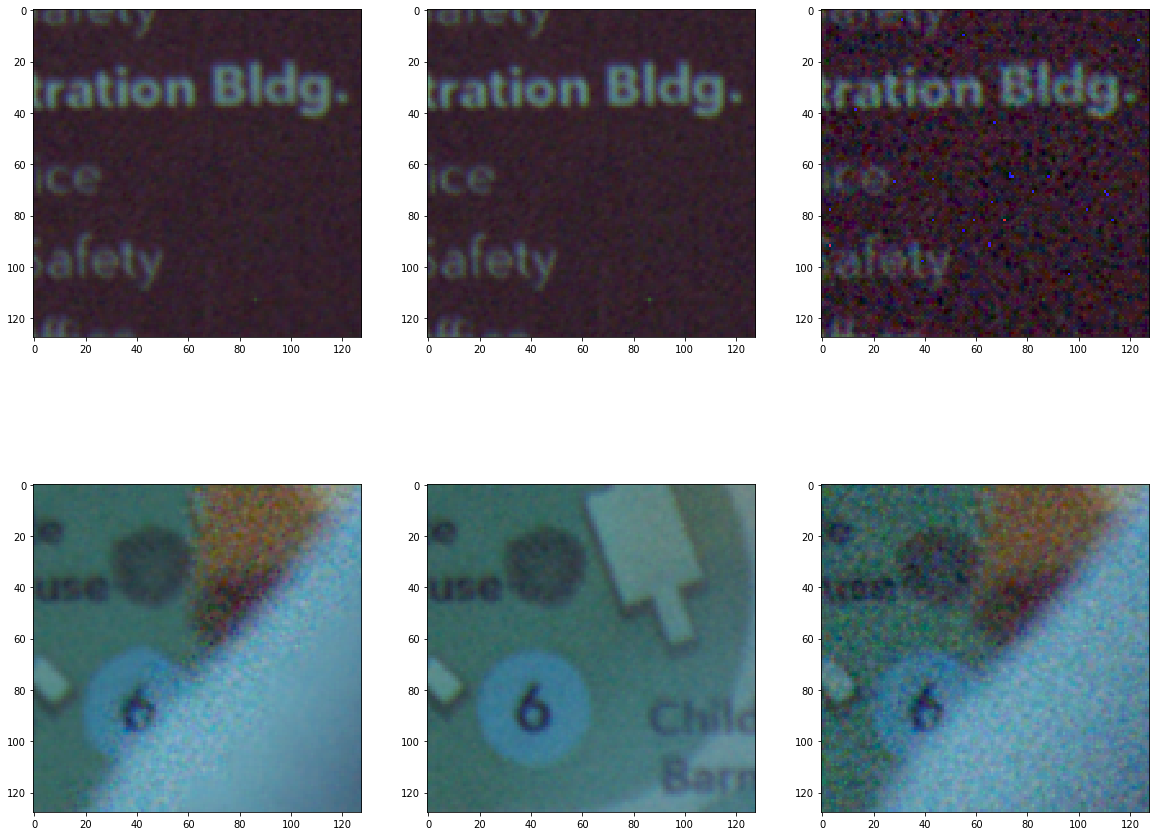

In [16]:
rgbIm_adj = cv2.imread("rgbIm_adj_ref{}.png".format(ref_idx))[..., ::-1]
rgbIm_adj_single = cv2.imread("rgbIm_adj_single_ref{}.png".format(ref_idx))[..., ::-1]
rgbIm_adj_merge = cv2.imread("rgbIm_adj_merge_ref{}.png".format(ref_idx))[..., ::-1]

fig, ax = plt.subplots(2, 3, figsize=(20, 16))
ax[0][0].imshow(rgbIm_adj_merge[1700:1828, 1020:1148])
ax[0][1].imshow(rgbIm_adj[1700:1828, 1020:1148])
ax[0][2].imshow(rgbIm_adj_single[1700:1828, 1020:1148])
ax[1][0].imshow(rgbIm_adj_merge[1300:1300+128, 1500-128:1500])
ax[1][1].imshow(rgbIm_adj[1300:1300+128, 1500-128:1500])
ax[1][2].imshow(rgbIm_adj_single[1300:1300+128, 1500-128:1500])
plt.show()